In [1]:
import math
import numpy as np
import scipy.sparse
import h5py
from matplotlib import pyplot as plt
from matplotlib import colormaps
from numba import *
from tqdm.notebook import tnrange, tqdm
import umap
import igraph
import leidenalg

/home/anders/pyenv_torch/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anders/pyenv_torch/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anders/pyenv_torch/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDepreca

### Example data

We use again the IFNAGRKO dataset. Log-normalization and PCA has already been performed.

Here is the result of the PCA:

In [2]:
with h5py.File("../ifnagrko_pca.h5") as f:
    pca = f['pca'][:].transpose()

ncells = pca.shape[0]

pca[:5,:5]

array([[ 16.28623584, -12.28097802,  -5.47207594, -21.76252769,
         -1.77129431],
       [-10.83887971,   0.33993333,   2.08093385,   0.69148338,
         -7.08986989],
       [ 12.58293331,   7.58620352,  -1.90409793,   7.65700522,
          3.03268977],
       [ 10.06454811,   6.13142251,  -2.11701715,   4.04206773,
          2.279775  ],
       [-10.0199706 ,  -0.89696176,   6.20651074,  -0.53720203,
         -6.59578868]])

### Standard UMAP

We use the UMAP package to perform the transformation.

Note that we stick to default values except for one thing: We have fixed the hyperparameters $a$ and $b$ both to 1.

In [3]:
ump0 = umap.UMAP( a=1, b=1, verbose=True ).fit( pca )

UMAP(a=1, b=1, verbose=True)
Fri Jun  7 16:56:17 2024 Construct fuzzy simplicial set
Fri Jun  7 16:56:17 2024 Finding Nearest Neighbors
Fri Jun  7 16:56:17 2024 Building RP forest with 12 trees
Fri Jun  7 16:56:22 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jun  7 16:56:39 2024 Finished Nearest Neighbor Search
Fri Jun  7 16:56:42 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Jun  7 16:56:51 2024 Finished embedding


Here's a scatter plot of the result

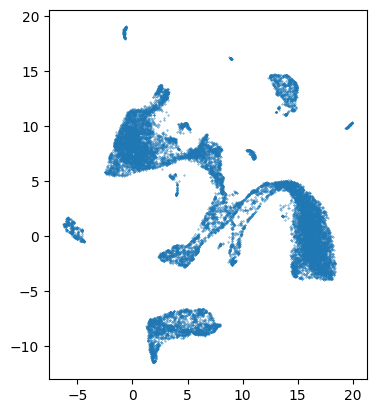

In [4]:
plt.scatter( ump0.embedding_[:,0], ump0.embedding_[:,1], s=.1 )
plt.gca().set_aspect('equal')

Next, we will recreate this "by hand".

### Find nearest-neighbors

We use a kd tree to find the 15 nearest neighbors:

In [5]:
nnbgs = 14
nndist, nnidx = scipy.spatial.KDTree( pca ).query( pca, k=nnbgs+1 )

`nnidx` is now an array of shape `ncells` by `nnbgs+1`, giving for each cell the indices of its nearest neighbours:

In [6]:
nnidx[:5,:5]

array([[    0,  2503,  4612,  2816,  2696],
       [    1, 12411, 11119,  9816,  6432],
       [    2, 10072,  9511,  3942,  7029],
       [    3, 12406,  2607, 16033,  8034],
       [    4, 10059, 10134,  3873,  5332]])

In [7]:
nndist[:5,:5]

array([[0.        , 2.91554959, 3.87197945, 3.94469136, 4.04883681],
       [0.        , 1.74307066, 1.8722435 , 1.90254414, 1.94840715],
       [0.        , 2.3056303 , 2.36507558, 2.40163638, 2.56152625],
       [0.        , 2.21332819, 2.88892446, 2.91914098, 2.93972125],
       [0.        , 2.8192931 , 3.05565062, 3.12995438, 3.15387043]])

As each cell is listed as its own nearest neighbor, we remove the first column, leaving us with `nnbgs` columns.

In [8]:
nnidx = nnidx[:,1:]

The array `nndist` contains the distances of the neighbours to the respective cell. The array has the same shape. We also remove the first column.

In [9]:
nndist = nndist[:,1:]

### Similarity score

The UMAP algorithm suggests to convert these distances (we write $d_{ij}$ for the distance from cerll $i$ to cell $j$) into similarity scores $\mu_{ij}$ using an exponential: For the similarity of a cell $i$ to another cell $j$ that is among its $k$ nearest neighbors, we set
$$\mu_{i\rightarrow j} = a_i e^{-d_{ij}/\sigma_i}.$$
The similarity score of cell $i$ to any cell further away is set to 0.

The UMAP paper argues that the metric in the high-dimensional space should be locally re-adjusted such that the point density becomes roughly uniform, because only then does the algorithm's theoretical justification hold.

They suggest to set $a_i=e^{d_{ii_1}/\sigma_i}$, where $d_{ii_1}$ is the distance of cell $i$ to its nearest neighbor. This means that the similarity score from any cell to its nearest neighbor is 1.

Furthermore, the decay constant $\sigma_i$ is chosen such that 
$$\sum_{j=1}^k \mu_{i\rightarrow j} = \log_2 k,$$
where $k$ is the numebr of nearest neighbors. 

Note that these values are not symmetric under exchange of $i$ and $j$. We therefore call these numbers the "directed" similarity scores.

To calculate them, we find the decay constants $\sigma_i$ using a simple root-finding approach:

In [10]:
mu_dir = np.zeros_like( nndist )

for i in range(mu_dir.shape[0]):
    res = scipy.optimize.root( 
        lambda sigma: np.exp( -( nndist[i,:] - nndist[i,0] ) / sigma ).sum() - math.log2(nnbgs+1), 
        nndist[i,1]-nndist[i,0] )
    assert res.success
    mu_dir[i,:] = np.exp( -( nndist[i,:] - nndist[i,0] ) / res.x )

mu_dir[:5,:5]

array([[1.        , 0.38127649, 0.35432688, 0.31901082, 0.22263436],
       [1.        , 0.4790331 , 0.40307648, 0.31038503, 0.24439773],
       [1.        , 0.78010108, 0.66960721, 0.34335116, 0.21518077],
       [1.        , 0.34741612, 0.33137074, 0.3208687 , 0.25827415],
       [1.        , 0.47652488, 0.37747247, 0.35019673, 0.34993508]])

In [11]:
( np.abs( mu_dir.sum(1) - math.log2(nnbgs+1) ).max(),
  np.abs( mu_dir[:,0] - 1. ).max() )

(8.72191208145523e-13, 0.0)

### Symmetrizing the similarity scores

The UMAP papers' author suggest to consider the rows of this matrix as neighborhood fuzzy sets: Each cell gets a neighborhood, which is a fuzzy set, containing the cell's nearest neighbor with probability one and the next $k-1$ neighbours with a probability that decays exponentially with distance. The union of all these forms a "skeleton" or backbone, building a fuzzy simplical complex that covers the manifold.

For this to make sense, we need a symmetric neighborhood relationship. Therefore, we make the union of the reciprocal fuzzy membership probabilities. Given two events $A$ and $B$ with probabilities $p_A$ and $p_B$, the probability of at least one of the two happening is $p_A+p_B-p_Ap_B$.

Therefore, we set
$$ \mu_{ij} = \mu_{i\rightarrow j}+\mu_{j\rightarrow i}- \mu_{i\rightarrow j}\mu_{j\rightarrow i}.$$

To calculate this, we first set up a sparse matrix whose entries are given by the $\mu_{i\rightarrow j}$:

In [12]:
adj_dir = scipy.sparse.coo_array( (ncells,ncells) )
for i in range(nnbgs):
    adj_dir += scipy.sparse.coo_array( (mu_dir[:,i], (np.arange(ncells), nnidx[:,i]) ), shape=(ncells,ncells) )
adj_dir

<18302x18302 sparse array of type '<class 'numpy.float64'>'
	with 256228 stored elements in Compressed Sparse Row format>

This code works as follows: A sparse matrix in COOrdinate form takes three vectors, provided as `(data, (row,col))`, that indicate that positions and values of all non-zero matrix entries.
The `i`-the iteration of the for-loop constructs such a matrix for the symmetry score of each cell to its `i`-th nearest neighbor. Adding up these matrices yields the matrix formed by the $\mu_{i \rightarrow j}$.

The values $\mu_{j \rightarrow i}$ are the matrix elements of the transpsoe of that matrix. The symmetrization is hence calculated with:

In [13]:
adj_symm = adj_dir + adj_dir.transpose() - adj_dir.multiply( adj_dir.transpose() )
adj_symm

<18302x18302 sparse array of type '<class 'numpy.float64'>'
	with 379018 stored elements in Compressed Sparse Row format>

Note that the `multiply` method used here performs element-wise multiplication, not matrix multiplication, which is waht we need here.

#### Histograms

Here are histograms of the nonzero matrix elements of the directed and the symmetrized similarity-score matrix:

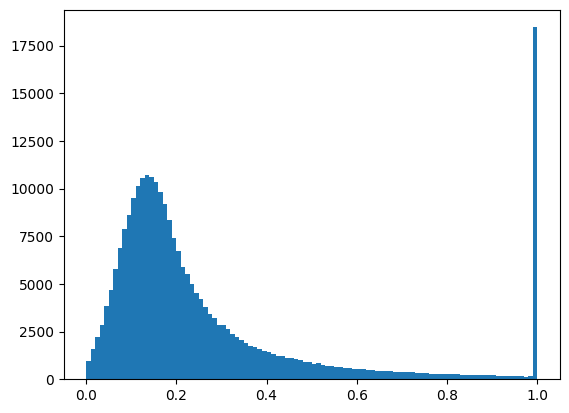

In [14]:
plt.hist( adj_dir.data, 100 );

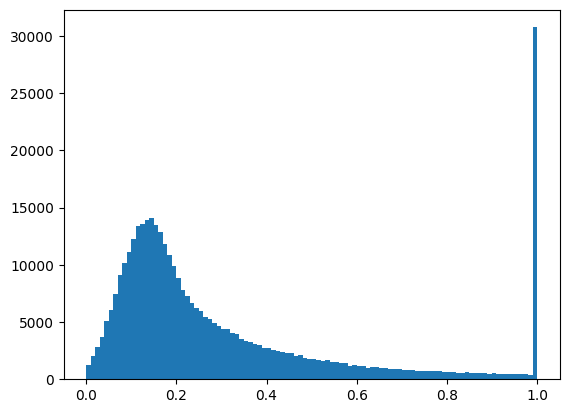

In [15]:
plt.hist( adj_symm.data, 100 );

### Compare with UMAP package's graph

Number of edges in our graph?

In [16]:
(adj_symm>0).sum()

379018

For how many of these does the edge weight differ from the one computed by the UMAp package by more than .01?

In [17]:
( np.abs( adj_symm - ump0.graph_ ) > .01 ).sum()

4146

These are really few. Undfortunately, there seems to be some mistake here that badly messes up things, because the code below only works with the matrix from the UMAP package, not the matrix we have just computed ourselves. Until I find this one, I replace our matrix with the one from the package:

In [18]:
# DEBUG ONLY
adj_symm = scipy.sparse.csr_array( ump0.graph_ )

### Connected components

The symmetrized matrix can also be interpreted as an adjacency matrix of an undirected weighted graph. 

If we binarize the matrix, i.e., set all non-zero weights to 1, we get the point cloud's $k$-nearest-neighbors graph.

We ask whether this graph is connected:

In [19]:
ncc, ccidx = scipy.sparse.csgraph.connected_components( adj_symm>0 )
ncc

3

No, it is not. We have two connection components that are not connected with each other.

How many cells fall into each component?

In [20]:
np.bincount(ccidx)

array([17820,   137,   345])

To make our life easier, we remove that small components and only keep the "main component" (`mc`), which has index 0.

In [21]:
adj_mc = adj_symm[ ccidx==0, :][:, ccidx==0 ]
adj_mc.shape

(17820, 17820)

### Leiden clustering

Merely so that we have a way of colouring our cells in subsequent plots, we perform a Leiden clustering.

To this end, we binarize the adjacency matrix (i.e., set all non-zero entries to 1) and form a graph from that.

In [22]:
nngraph = igraph.Graph.Adjacency( adj_mc>0 )

Then, we run the Leiden algorithm.

In [23]:
clm = leidenalg.find_partition( nngraph, leidenalg.ModularityVertexPartition ).membership

Now, we have a vector of cluster memberships. Here, for the first 10 cells:

In [24]:
clm[:10]

[7, 1, 15, 4, 0, 3, 2, 0, 6, 0]

We can colour the UMAP from before using this:

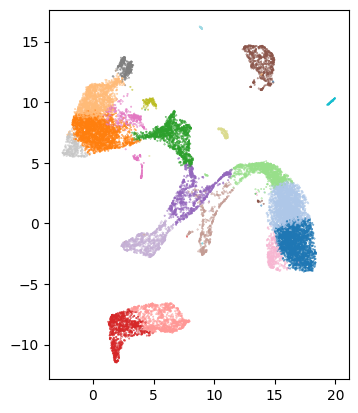

In [25]:
palette = plt.colormaps['tab20'](range( max(clm)+1 ))

plt.scatter( ump0.embedding_[ ccidx==0, 0 ], ump0.embedding_[ ccidx==0, 1 ], s=.1, c=palette[clm] )
plt.gca().set_aspect('equal')

### Spectral clustering

We are still not ready to perform the actual UMAP algorithm, because we need an initial configuration. In the UMAP package, this is obtained via spectral clustering, so we do the same here:

We start by constructing the graph Laplacian of our weighted adjacency matrix. To this end, we first get a diagonal matrix D of the degrees of the graph vertices, i.e.
$$D_{ij}=\delta_{ij}\sum_{j'}\mu_{ij'}.$$

In [26]:
degdiag = scipy.sparse.diags( adj_symm.sum(0) )

The standard graph Laplacian is given by $L_0=D-A$, where $A$ is the adjacency matrix formed by the $\mu_{ij}$. Spectral clustering, however, works better, if one scales the Laplacian by dividing rows and columns by the square roots of the degrees, obtaining 
$$L=D^{-1/2}L_0 D^{-1/2} = I - D^{-1/2} A D^{-1/2}.$$

We get this scaled Laplacian,

In [27]:
invsqrtdegdiag = scipy.sparse.diags( 1 / np.sqrt( adj_mc.sum(0) ) )

scaled_laplacian = scipy.sparse.identity(adj_mc.shape[0]) - invsqrtdegdiag * adj_mc * invsqrtdegdiag

and get its 10 smallest (by magnitude) eigenvalues and their eigenvectors

In [28]:
evals, evecs = scipy.sparse.linalg.eigsh( scaled_laplacian, k=10, which='SM' )

Here are the eigenvalues:

In [29]:
evals

array([-7.61673033e-10,  4.62136971e-04,  5.68060284e-04,  8.16269430e-04,
        1.15417724e-03,  1.30719764e-03,  2.52493486e-03,  2.87093380e-03,
        4.12936255e-03,  6.07355757e-03])

As expected, the lowest eigenvalue is 0. There is only one eigenvalue because our graph is connected. Had we kept the second connection component, we would have obtained a two-dimensional eigenspace to the zero eigenvalue. This is, why we removed it above -- so that we do not have to deal with this issue here.

The eigenvector corresponding to the 0 eigenvalue would be constant for the usncaled Laplacian. Due to the scaling, it is now proportional to the square roots of the vertex degrees:

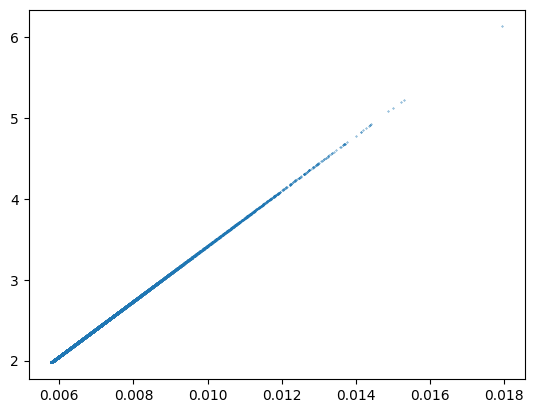

In [30]:
plt.scatter( evecs[:,0], np.sqrt(adj_mc.sum(0)), s=.1 )

This vector is hence not of interest. The next two eigenvectors, however, are. We plot them here:

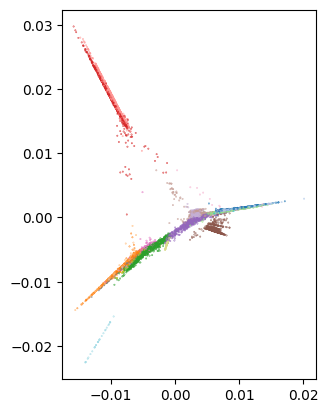

In [37]:
plt.scatter( evecs[:,1], evecs[:,2], s=.1, c=palette[clm] )
plt.gca().set_aspect('equal')

This is what we will use as initial configuration for the UMAP algorithm.

### UMAP

In [50]:
@njit
def squared_distance_2d( v1, v2 ):
    dx = v2[0] - v1[0]
    dy = v2[1] - v1[1]
    return dx*dx + dy*dy

@njit
def clip( x ):
    if x < -4.:
        return -4.
    elif x > 4.:
        return 4.
    else:
        return x
        
@njit(parallel=True,fastmath=True)
def run_epoch( ump, edgefr, edgeto, edgewt, lr ):
    if ump.shape[1] != 2:
        raise ValueError( "Must be 2D embedding" )
    n_vertices = ump.shape[0]
    ump2 = ump.copy()
    for i in prange(edgefr.shape[0]):
        
        if np.random.rand() > edgewt[i]: 
            continue
        
        # Choose edge
        v1 = edgefr[i]
        v2 = edgeto[i]
                
        # squared distance
        d2 = squared_distance_2d( ump[v1,], ump[v2,] )
               
        # attractive force
        grad_coef = -2. / ( d2 + 1. )
        for k in range(2):
            grad = grad_coef * ( ump[v1,k] - ump[v2,k] )
            grad = clip( grad )
            ump2[v1,k] += lr * grad
            ump2[v2,k] -= lr * grad
        
        
        # Choose 5 rejection partners
        for j in range(5):
            v2 = np.random.randint(n_vertices)
        
            d2 = squared_distance_2d( ump[v1,], ump[v2,] )
            grad_coef = 2. / ( ( d2 + 1. ) * ( d2 + .001 ) )
            for k in range(2):
                grad = grad_coef * ( ump[v1,k] - ump[v2,k] )
                grad = clip( grad )
                ump2[v1,k] += lr * grad * .03   # <- strangly low gamma here:
                                                 # 0.03 normally, 0.008 for binarized matrix
    return ump2


In [51]:
ump = evecs[:,1:3].copy()
adj_mc_coo = adj_mc.tocoo()
lr = 1.

  0%|          | 0/1000 [00:00<?, ?it/s]

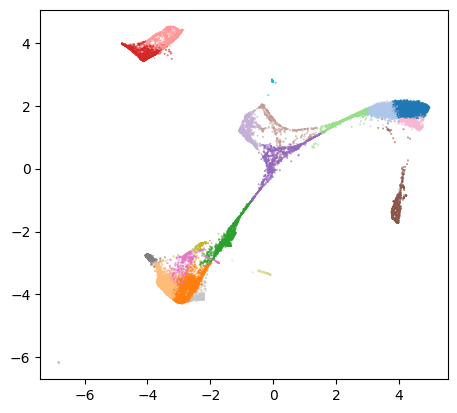

In [53]:
for i in tnrange(1000):
    ump = run_epoch( ump, adj_mc_coo.row, adj_mc_coo.col, adj_mc_coo.data, lr )
    #ump = run_epoch( ump, adj_mc_coo.row, adj_mc_coo.col, np.ones_like(adj_mc_coo.data), lr )
    lr = .997*lr
plt.scatter( ump[:,0], ump[:,1], s=.1, c=palette[clm] )
plt.gca().set_aspect('equal')

In [46]:
math.sqrt( ((pca[13239,:]-pca[512,:])**2).sum() )

2.401280267835413

In [36]:
( nnidx[512,0], nndist[512,0] )

(13239, 2.401280267835413)